<a href="https://colab.research.google.com/github/leochartrand/IFT615/blob/main/CNN/CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Cette démonstration est inspirée du cours "CS50’s Introduction to Artificial Intelligence with Python" donné à l'Université d'Harvard.*

https://cs50.harvard.edu/ai/2024/

https://creativecommons.org/licenses/by-nc-sa/4.0/





In [79]:
import numpy as np
from PIL import Image, ImageFilter
from skimage.io import imshow
import matplotlib.pyplot as plt
from IPython.display import display
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

On peut commencer par charger le jeux de données MNIST:

In [71]:
batch_size = 100

train_data = torchvision.datasets.MNIST(root = './', train = True,
                                        transform = torchvision.transforms.ToTensor(),
                                        download = True)

train_dataloader = torch.utils.data.DataLoader(dataset = train_data,
                                          batch_size = batch_size,
                                          shuffle = True)

test_data = torchvision.datasets.MNIST(root = './', train = False,
                                       transform = torchvision.transforms.ToTensor())

test_dataloader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = batch_size,
                                          shuffle = False)

Profitons en pour observer quelques exemples du jeux de données:

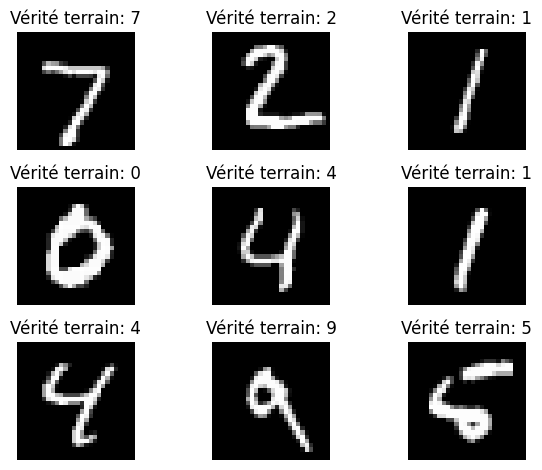

In [67]:
index, (ex_data, ex_labels) = next(enumerate(test_dataloader))

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.axis('off')
  plt.tight_layout()
  plt.imshow(ex_data[i][0], cmap='gray')
  plt.title("Vérité terrain: %d"%(ex_labels[i]))
fig.show()

In [91]:
model = nn.Sequential(

    # Couche convolutive. Apprend 32 filtres en utilisant un noyau 3x3
    nn.Conv2d(1, 32, (3, 3)),

    # Activation ReLU
    nn.ReLU(),

    # Couche de max-pooling de taille 2x2
    nn.MaxPool2d((2, 2)),

    # On applatie les données
    nn.Flatten(),

    # Couche dense
    nn.Linear(5408, 128),
    nn.ReLU(),

    # Couche dense finale avec comme sortie les probabilitées pour les 10 chiffres
    nn.Linear(128, 10),
)

In [92]:
# On instancie un optimiseur qui s'occupe de la descente de gradient
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# On instancie notre fonction de parte
criterion = nn.CrossEntropyLoss()

# Entraînons maintenant notre modèle!

In [93]:
# On garde un historique de l'entraînement pour visualiser nos résultats
loss_history = []

epochs = 5

for epoch in range(epochs):
  print("Epoch %d/%d"%(epoch+1, epochs))
  progress = tqdm(train_dataloader)
  for index, (data, labels) in enumerate(progress):
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    progress.set_description("Loss: %.4f"%loss.item())

Epoch 1/10


Loss: 0.3826: 100%|██████████| 600/600 [00:47<00:00, 12.59it/s]


Epoch 2/10


Loss: 0.2038: 100%|██████████| 600/600 [00:48<00:00, 12.44it/s]


Epoch 3/10


Loss: 0.0952: 100%|██████████| 600/600 [00:55<00:00, 10.86it/s]


Epoch 4/10


Loss: 0.1674: 100%|██████████| 600/600 [01:02<00:00,  9.54it/s]


Epoch 5/10


Loss: 0.0696: 100%|██████████| 600/600 [00:47<00:00, 12.58it/s]


Epoch 6/10


Loss: 0.0663: 100%|██████████| 600/600 [00:49<00:00, 12.07it/s]


Epoch 7/10


Loss: 0.0522: 100%|██████████| 600/600 [00:47<00:00, 12.60it/s]


Epoch 8/10


Loss: 0.0302: 100%|██████████| 600/600 [00:51<00:00, 11.75it/s]


Epoch 9/10


Loss: 0.0899: 100%|██████████| 600/600 [00:49<00:00, 12.24it/s]


Epoch 10/10


Loss: 0.0237: 100%|██████████| 600/600 [00:49<00:00, 12.17it/s]


On peut visualiser l'apprentissage de notre modèle à l'aide de la librairie ***matplotlib***:

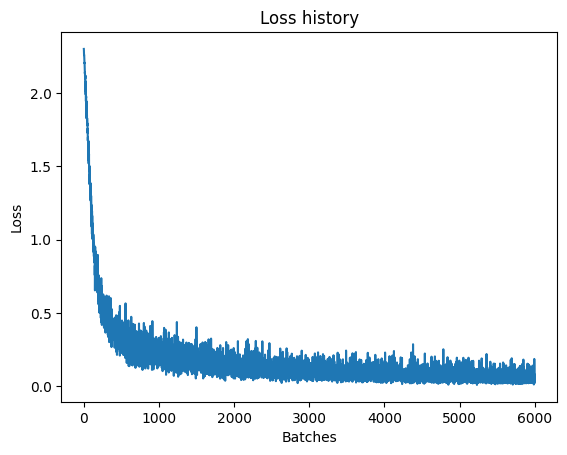

In [97]:
plt.plot(range(epochs*len(train_dataloader)), loss_history)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

Évaluons maintenant la précision de notre modèle sur le jeu de données de test:

In [99]:
correct = 0
total = 0
for data, labels in test_dataloader:
  output = model(data)
  _, predictions = torch.max(output,1)
  correct += (predictions == labels).sum()
  total += labels.size(0)

print('Précision du modèle: %.3f %%' %(100*correct/total))

Précision du modèle: 98.170 %
